# Model Zoo

### 1. Persistence
- `Pers1` : observation from day before at the same time of day (no diurnal, seasonal correction)
- `Pers2` : observation from day before & adaptive scale
- `Pers3` : adaptive scale & diurnal, seasonal component added

### 2. Physics added
Clearsky indices (GHI, DNI etc.)

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings

from matplotlib import pyplot as plt

from scipy.stats import probplot, cumfreq, norm
from scipy.interpolate import interp1d
from scipy.integrate import quad, nquad

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import properscoring as ps

## Implementation of PP-Plot, PP-plot Metric & Sanity Check

In [2]:
def ppPlot(y_obs, mu_hat, sigma_hat, comment="-"): 
    # '''Visualize the PP- (probability probability) plot. Asumes conditional Gaussiantiy, provided arrays of aobservations, mu, and sigma estimates'''
    assert len(y_obs)==len(mu_hat), "Observations and expected value lists/arrays must have same length."
    sigma_hat = [sigma_hat]*len(y_obs) if (isinstance(sigma_hat, float) or isinstance(sigma_hat, int)) else sigma_hat
    assert len(mu_hat)==len(sigma_hat), "Expected value and sigma lists/arrays must have same length."

    # sort dist. parameters accordingly (w.r.t. observation size)
    mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
    sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
    # sort observations
    y_obs = sorted(y_obs)

    # F: empirical. CDF
    empCDF = ECDF(y_obs)
    F_ = empCDF(y_obs)

    # G: predicted, conditional CDF
    G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])


    plt.suptitle('PP-Plot (n={})'.format(len(y_obs)), fontsize=18, y=1.0175)
    plt.title(comment, fontsize=15)
    plt.plot([0,1], [0,1], 'r-', zorder=1)
    plt.scatter(F_, G_, zorder=2)
    plt.show()
    
    
def ppArea(y_obs, mu_hat, sigma_hat): 
    assert len(y_obs)==len(mu_hat), "Observations and expected value lists/arrays must have same length."
    sigma_hat = [sigma_hat]*len(y_obs) if (isinstance(sigma_hat, float) or isinstance(sigma_hat, int)) else sigma_hat
    assert len(mu_hat)==len(sigma_hat), "Expected value and sigma lists/arrays must have same length."

    # sort dist. parameters accordingly (w.r.t. observation size)
    mu_hat    = [x for _, x in sorted(zip(y_obs, mu_hat))]
    sigma_hat = [x for _, x in sorted(zip(y_obs, sigma_hat))]
    # sort observations
    y_obs = sorted(y_obs)

    # F: empirical. CDF
    empCDF = ECDF(y_obs)
    F_ = empCDF(y_obs)

    # G: predicted, conditional CDF
    G_ = np.array([norm.cdf(_, loc=meanLoc, scale=sigmaLoc) for (_, meanLoc, sigmaLoc) in zip(y_obs, mu_hat, sigma_hat)])

    # interpolate points
    f_interpol = interp1d(x=F_,y=G_)
    f_diverg = lambda x : abs(f_interpol(x) - x)

    # measure shaded area (quadrature)
    warnings.filterwarnings("ignore")
    ppArea = round(quad(func=f_diverg, a=min(F_), b=max(F_), limit=1000)[0], 8)

    return ppArea

def ppPlotMetric(y_obs, mu_hat, sigma_hat, mu_base, sigma_base):
    '''Computes the PP plot metric (i.e. relative reduction of shaded area when switching from baseline to predictor).'''
    areaBase = ppArea(y_obs, mu_base, sigma_base)
    areaPredict = ppArea(y_obs, mu_hat, sigma_hat)
    
    return round(100. * ((areaBase - areaPredict) / areaBase), 2)


### Sanity-check the PP-plot methods

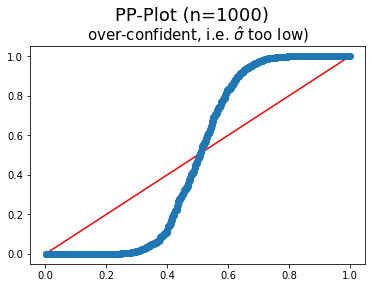

PP-plot metric: 0.0% (Baseline)


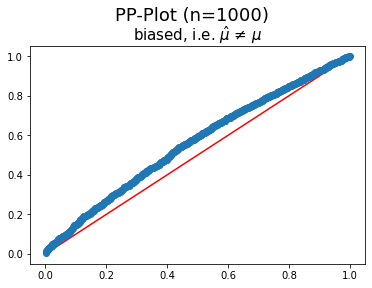

PP-plot metric: 64.27%


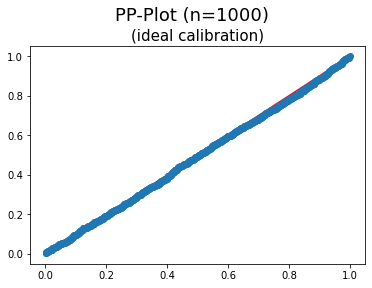

PP-plot metric: 94.13%


In [3]:
# A. Over-confident
N = 1000
rnd = np.random.normal(loc=2, scale=2, size=N)
mus1 = [2]*N
sig1 = 0.5
ppPlot(rnd, mus1, sig1, "over-confident, i.e. $\hat{\sigma}$ too low)")
print('PP-plot metric: {}% (Baseline)'.format(ppPlotMetric(rnd, mus1, sig1, mus1, sig1)))

# B. Biased
mus2 = [1.5]*N
sig2 = 2
ppPlot(rnd, mus2, sig2, "biased, i.e. $\hat{\mu}$ ≠ $\mu$")
print('PP-plot metric: {}%'.format(ppPlotMetric(rnd, mus2, sig2, mus1, sig1)))

# C. Calibrated
mus3 = [2]*N
sig3 = 2
ppPlot(rnd, mus3, sig3, "(ideal calibration)")
print('PP-plot metric: {}%'.format(ppPlotMetric(rnd, mus3, sig3, mus1, sig1)))


## Load & split Data: *Train*, *Val* and *Test*

In [4]:
# load data
df    = pd.read_csv('df.csv', parse_dates=['date'])
df_ts = pd.read_csv('df_ts.csv', parse_dates=['date'])

# delete NaN's
df    = df[df['Y'] != -999]
df_ts = df_ts[df_ts['Y'] != -999]

# add day of the year (DoY)
df['DoY'] = df['date'].dt.dayofyear.map(lambda x : np.sin((2*np.pi*x) / (365.0)))

X, y = df.drop(labels=['date', 'Y'], axis=1).to_numpy(), df['Y'].to_numpy()

# regression split (LASSO, ...)
seed_1, seed_2 = 5645, 8373
X_tr, X_, y_tr, y_     = train_test_split(X,  y,  train_size=280, random_state=seed_1) #  train: 280
X_te, X_va, y_te, y_va = train_test_split(X_, y_, train_size=60,  random_state=seed_2) # "test" : 60  -> val: 59

# time series split (...)
lTr   = datetime.strptime('2021-10-07 12:00:00', '%Y-%m-%d %H:%M:%S') # 280
lVa   = datetime.strptime('2021-12-06 12:00:00', '%Y-%m-%d %H:%M:%S') # 60
lTe   = datetime.strptime('2022-03-23 12:00:00', '%Y-%m-%d %H:%M:%S') # 59`

## 1. `Pers` 
Observation from previous day (same time of the day, i.e. noon) as $\hat{\mu}_{t}$. Same (estimated) variance across year, i.e. $\hat{\sigma}^{2}$. Gaussianity as the assumed conditional distribution for probabilistic prediction, i.e. 
$$ Y_{t+1} \sim \mathcal{N}(Y_{t}, \hat{\sigma}^{2}) $$

In [5]:
# train mu
pers1_tr_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].to_numpy()

# check variance
CRPS_list = []
sigma_list = np.linspace(15, 300, 500)
for sigmaLoc in sigma_list:
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=pers1_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
sigma_pers1_hat = sigma_list[list(CRPS_list == min(CRPS_list)).index(True)]

# CRPS: Train Set
# - train
CRPS_pers1_tr = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_tr_mu, sig=sigma_pers1_hat))


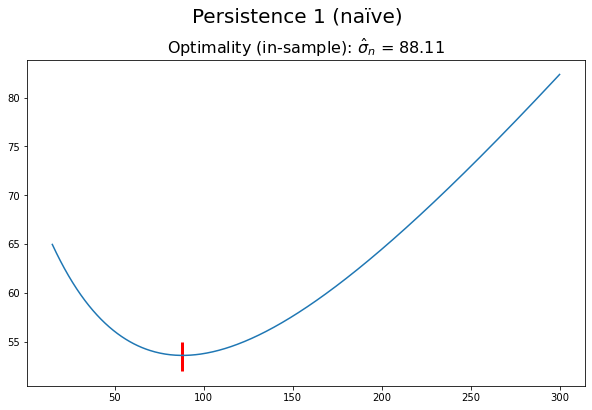

In [6]:
# Visualize optimal standard deviation
plt.figure(figsize=(10,6))
plt.suptitle("Persistence 1 (naïve)", fontsize=20, y=1.002)
plt.title("Optimality (in-sample): $\hat{\sigma}_{n}$ = " + str(round(sigma_pers1_hat, 2)), fontsize=16)
plt.plot(sigma_list, CRPS_list)
plt.vlines(x=sigma_pers1_hat, ymin=52, ymax=55, color='red', linewidth=3)

plt.show()

### Compute test and validation metrics CRPS

In [7]:
# Validation Set
pers1_va_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].to_numpy()
# - val
CRPS_pers1_va = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_va_mu, sig=sigma_pers1_hat))

# Test Set
pers1_te_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].to_numpy()
# - test
CRPS_pers1_te = np.mean(ps.crps_gaussian(Y_tr, mu=pers1_te_mu, sig=sigma_pers1_hat))


## 2. `Pers` 
Observation from previous day (same time of the day, i.e. noon) as $\hat{\mu}_{t}$. 
Additionally, refined time-dependent variance a lagged estimator of $k$ previous observations $\hat{\sigma}^{2}_{t} = \sigma^{2}(Y_{t}, ... , Y_{t-k+1})$. 
Gaussianity as the assumed conditional distribution for probabilistic prediction, i.e. 
$$ Y_{t+1} \sim \mathcal{N}(Y_{t}, \hat{\sigma}^{2}_{t}) $$

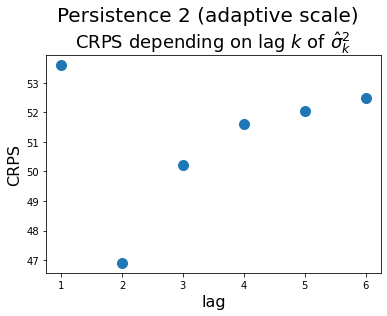

In [8]:
# train mu
pers2_tr_mu = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].shift(1).fillna(131.9).to_numpy()
Y_tr        = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].to_numpy()

# check variance
CRPS_list = []
lag_list = range(1,7)
for k in lag_list:
    sigmaLoc = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=pers2_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
k_star = lag_list[list(CRPS_list == min(CRPS_list)).index(True)]

plt.suptitle("Persistence 2 (adaptive scale)", fontsize=20, y=1.05)
plt.title("CRPS depending on lag $k$ of $\hat{\sigma}^{2}_{k}$", fontsize=18)
plt.scatter(lag_list, CRPS_list, s=100)
plt.xlabel("lag",  fontsize=16)
plt.ylabel("CRPS", fontsize=16)
plt.show()



In [9]:
# CRPS: Train Set
# - train
Y_tr           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].to_numpy()
pers2_tr_mu    = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].shift(1).fillna(131.9).to_numpy()
pers2_tr_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers2_tr = np.mean(ps.crps_gaussian(Y_tr, mu=pers2_tr_mu, sig=pers2_tr_sigma))

# CRPS: Validation Set
Y_va           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].to_numpy()
pers2_va_mu    = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
pers2_va_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers2_va  = np.mean(ps.crps_gaussian(Y_va, mu=pers2_va_mu, sig=pers2_va_sigma))

# Test Set
Y_te           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].to_numpy()
pers2_te_mu    = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].shift(1).fillna(131.9).to_numpy()
pers2_te_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers2_va  = np.mean(ps.crps_gaussian(Y_te, mu=pers2_te_mu, sig=pers2_te_sigma))


## 3. `Pers` 
Previous observation (Morning) and previous day's observation (same time of the day, i.e. noon) as $\hat{\mu}_{t}$.
Further refinement of the conditional mean through estimation of a *diurnal* $D_{t}$ and *seasonal* component $S_{t}$.
Additionally, refined time-dependent variance a lagged estimator of $k$ previous observations $\hat{\sigma}^{2}_{t} = \sigma^{2}(Y_{t}, ... , Y_{t-k+1})$. 
Gaussianity as the assumed conditional distribution for probabilistic prediction, i.e. 
$$ Y_{t+1} \sim \mathcal{N}(\mu(Y_{t}, S_{t}, D_{t}), \hat{\sigma}^{2}_{t}(Y_{t}, ..., Y_{t-k+1})) $$

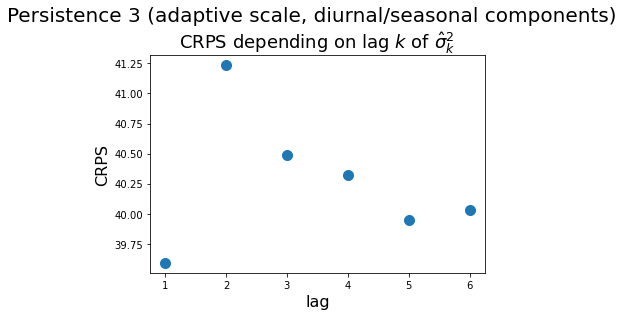

In [10]:
# add log lags
for k in range(0,4):
    df_ts['Y_L{}'.format(k)] = df_ts['Y'].shift(k).map(lambda x : np.log(max(x, 10)))

# add day of the year (DoY)
df_ts['DoY1'] = df_ts['date'].dt.dayofyear.map(lambda x : np.sin((2*np.pi*x) / (365.0)))
df_ts['DoY2'] = df_ts['date'].dt.dayofyear.map(lambda x : np.cos((2*np.pi*x) / (365.0)))

# delete NaN rows
df_ts = df_ts.iloc[3: , :]

# subset for regression (!only noon, i.e. 12pm-dated observations are to be predicted)
df_ts_tr = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]
df_ts_va = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]
df_ts_te = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]

# delete certain columns
df_ts_tr = df_ts_tr.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_va = df_ts_va.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_te = df_ts_te.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)

# regression arrays: (y, X)
# - train
y_log_obs_tr = df_ts_tr['Y_L0'].to_numpy()
X_log_obs_tr = df_ts_tr[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()
# - val
y_log_obs_va = df_ts_va['Y_L0'].to_numpy()
X_log_obs_va = df_ts_va[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()
# - test
y_log_obs_te = df_ts_te['Y_L0'].to_numpy()
X_log_obs_te = df_ts_te[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()

# fit linear regression
pers3_lm = LinearRegression()
pers3_lm.fit(y=y_log_obs_tr,X=X_log_obs_tr)

# mu estimates :  (back-transform predicted log's)
pers3_tr_mu = np.exp(pers3_lm.predict(X_log_obs_tr))

# sigma estimates : 
Y_tr  = np.exp(y_log_obs_tr)

# check variance
CRPS_list = []
lag_list = range(1,7)
for k in lag_list:
    sigmaLoc = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=pers3_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
k_star = lag_list[list(CRPS_list == min(CRPS_list)).index(True)]

plt.suptitle("Persistence 3 (adaptive scale, diurnal/seasonal components)", fontsize=20, y=1.05)
plt.title("CRPS depending on lag $k$ of $\hat{\sigma}^{2}_{k}$", fontsize=18)
plt.scatter(lag_list, CRPS_list, s=100)
plt.xlabel("lag",  fontsize=16)
plt.ylabel("CRPS", fontsize=16)
plt.show()

In [11]:
# CRPS: Train Set
# - train
Y_tr           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].to_numpy()
pers3_tr_mu    = np.exp(pers3_lm.predict(X_log_obs_tr))
pers3_tr_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers3_tr = np.mean(ps.crps_gaussian(Y_tr, mu=pers3_tr_mu, sig=pers3_tr_sigma))

# CRPS: Validation Set
Y_va           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].to_numpy()
pers3_va_mu    = np.exp(pers3_lm.predict(X_log_obs_va))
pers3_va_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers3_va  = np.mean(ps.crps_gaussian(Y_va, mu=pers3_va_mu, sig=pers3_va_sigma))

# Test Set
Y_te           = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].to_numpy()
pers3_te_mu    = np.exp(pers3_lm.predict(X_log_obs_te))
pers3_te_sigma = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]['Y'].rolling(k_star).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!

CRPS_pers3_te  = np.mean(ps.crps_gaussian(Y_te, mu=pers3_te_mu, sig=pers3_te_sigma))

In [ ]:
# HOW TO SUBSET

#(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)
#(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)
#(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)


In [ ]:
X, y = df.drop(labels=['date', 'Y'], axis=1).to_numpy(), df['Y'].to_numpy()

# regression split (LASSO, ...)
seed_1, seed_2 = 5645, 8373
X_tr, X_, y_tr, y_     = train_test_split(X,  y,  train_size=280, random_state=seed_1) #  train: 280
X_te, X_va, y_te, y_va = train_test_split(X_, y_, train_size=60,  random_state=seed_2) # "test" : 60  -> val: 59

# time series split (...)
lTr   = datetime.strptime('2021-10-07 12:00:00', '%Y-%m-%d %H:%M:%S') # 280
lVa   = datetime.strptime('2021-12-06 12:00:00', '%Y-%m-%d %H:%M:%S') # 60
lTe   = datetime.strptime('2022-03-23 12:00:00', '%Y-%m-%d %H:%M:%S') # 59`

# 2. Additional atmospheric data (`PAIRS`)
Extension of the best persistence model of the previous chapter (`Pers3`)

In [23]:
df.drop(['ALLSKY_SFC_PAR_TOT'], axis=1).corr()

,ALLSKY_KT,SZA,CLRSKY_SFC_SW_DWN,DownLong,UpwardLong,uWind,DownShort,vWind,TempHeight,Y,DoY
ALLSKY_KT,1.000000,0.999926,0.651586,0.556844,0.722641,-0.230022,0.562907,0.012401,0.718318,0.578983,-0.072513
SZA,0.999926,1.000000,0.642602,0.552942,0.718075,-0.229331,0.556482,0.012385,0.713559,0.574889,-0.074191
CLRSKY_SFC_SW_DWN,0.651586,0.642602,1.000000,0.518015,0.685489,-0.188696,0.757588,-0.024012,0.697176,0.658489,0.118624
DownLong,0.556844,0.552942,0.518015,1.000000,0.864228,-0.158355,0.272202,0.108401,0.877207,0.170434,-0.342768
UpwardLong,0.722641,0.718075,0.685489,0.864228,1.000000,-0.149516,0.597532,0.182598,0.992535,0.509659,-0.427612
uWind,-0.230022,-0.229331,-0.188696,-0.158355,-0.149516,1.000000,-0.101052,0.227026,-0.176772,0.001208,0.010262
DownShort,0.562907,0.556482,0.757588,0.272202,0.597532,-0.101052,1.000000,0.016821,0.569614,0.855818,0.058529
vWind,0.012401,0.012385,-0.024012,0.108401,0.182598,0.227026,0.016821,1.000000,0.203099,0.050824,-0.046465
TempHeight,0.718318,0.713559,0.697176,0.877207,0.992535,-0.176772,0.569614,0.203099,1.000000,0.480593,-0.414204
Y,0.578983,0.574889,0.658489,0.170434,0.509659,0.001208,0.855818,0.050824,0.480593,1.000000,0.086214


In [20]:
# add log lags
for k in range(0,4):
    df_ts['Y_L{}'.format(k)] = df_ts['Y'].shift(k).map(lambda x : np.log(max(x, 10)))

# add day of the year (DoY)
df_ts['DoY1'] = df_ts['date'].dt.dayofyear.map(lambda x : np.sin((2*np.pi*x) / (365.0)))
df_ts['DoY2'] = df_ts['date'].dt.dayofyear.map(lambda x : np.cos((2*np.pi*x) / (365.0)))

# delete NaN rows
df_ts = df_ts.iloc[3: , :]

# subset for regression (!only noon, i.e. 12pm-dated observations are to be predicted)
df_ts_tr = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]
df_ts_va = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]
df_ts_te = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]

# delete certain columns
df_ts_tr = df_ts_tr.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_va = df_ts_va.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_te = df_ts_te.drop(columns = ['date', 'Y', 'ghi', 'dni', 'dhi'], axis=1) # 'Y' is in as log(Y_L0)

# regression arrays: (y, X)
# - train
y_log_obs_tr = df_ts_tr['Y_L0'].to_numpy()
X_log_obs_tr = df_ts_tr[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()
# - val
y_log_obs_va = df_ts_va['Y_L0'].to_numpy()
X_log_obs_va = df_ts_va[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()
# - test
y_log_obs_te = df_ts_te['Y_L0'].to_numpy()
X_log_obs_te = df_ts_te[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2']].to_numpy()

# fit linear regression
pers3_lm = LinearRegression()
pers3_lm.fit(y=y_log_obs_tr,X=X_log_obs_tr)

# mu estimates :  (back-transform predicted log's)
pers3_tr_mu = np.exp(pers3_lm.predict(X_log_obs_tr))

# sigma estimates : 
Y_tr  = np.exp(y_log_obs_tr)

# check variance
CRPS_list = []
lag_list = range(1,7)
for k in lag_list:
    sigmaLoc = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=pers3_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
k_star = lag_list[list(CRPS_list == min(CRPS_list)).index(True)]

plt.suptitle("Persistence 3 (adaptive scale, diurnal/seasonal components)", fontsize=20, y=1.05)
plt.title("CRPS depending on lag $k$ of $\hat{\sigma}^{2}_{k}$", fontsize=18)
plt.scatter(lag_list, CRPS_list, s=100)
plt.xlabel("lag",  fontsize=16)
plt.ylabel("CRPS", fontsize=16)
plt.show()

,date,ALLSKY_KT,SZA,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_SW_DWN,DownLong,UpwardLong,uWind,DownShort,vWind,TempHeight,Y,DoY
0,2021-01-01 06:00:00,-999.00,-999.00,0.00,0.00,282.0,306.0,-5.605,4.5,-1.140,271.889511,36.38,0.017213
1,2021-01-02 06:00:00,-999.00,-999.00,0.00,0.00,312.5,317.5,-1.260,31.0,-2.010,273.384491,69.20,0.034422
2,2021-01-03 06:00:00,-999.00,-999.00,0.00,0.00,300.0,311.0,2.005,46.5,0.700,271.682007,60.38,0.051620
3,2021-01-04 06:00:00,-999.00,-999.00,0.00,0.00,297.5,306.0,2.425,49.5,2.770,271.102493,82.12,0.068802
4,2021-01-05 06:00:00,-999.00,-999.00,0.00,0.00,308.5,313.0,2.590,30.5,-2.030,273.215500,89.98,0.085965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2022-02-25 06:00:00,0.36,89.06,2.10,7.45,283.0,302.0,0.490,134.0,-2.740,269.337494,169.77,0.821477
395,2022-02-26 06:00:00,0.46,88.95,2.95,9.58,201.5,291.5,3.835,205.5,3.025,266.492996,290.67,0.831171
396,2022-02-27 06:00:00,0.45,88.81,3.38,10.55,258.0,313.0,3.990,110.5,-0.355,270.916000,297.30,0.840618
397,2022-02-28 06:00:00,0.40,88.68,3.55,10.88,281.5,333.5,1.935,198.5,3.235,275.001495,283.73,0.849817


# 3. Physics-enhanced Model design
Extension of the best persistence model of the previous chapter (`Pers3` + `PAIRS`)

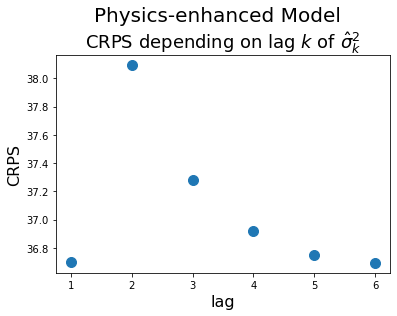

In [19]:
# add log lags
for k in range(0,4):
    df_ts['Y_L{}'.format(k)] = df_ts['Y'].shift(k).map(lambda x : np.log(max(x, 10)))

# add day of the year (DoY)
df_ts['DoY1'] = df_ts['date'].dt.dayofyear.map(lambda x : np.sin((2*np.pi*x) / (365.0)))
df_ts['DoY2'] = df_ts['date'].dt.dayofyear.map(lambda x : np.cos((2*np.pi*x) / (365.0)))

# delete NaN rows
df_ts = df_ts.iloc[3: , :]

# subset for regression (!only noon, i.e. 12pm-dated observations are to be predicted)
df_ts_tr = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]
df_ts_va = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lTr) & (df_ts.date <= lVa)]
df_ts_te = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date > lVa)]

# delete certain columns
df_ts_tr = df_ts_tr.drop(columns = ['date', 'Y'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_va = df_ts_va.drop(columns = ['date', 'Y'], axis=1) # 'Y' is in as log(Y_L0)
df_ts_te = df_ts_te.drop(columns = ['date', 'Y'], axis=1) # 'Y' is in as log(Y_L0)

# regression arrays: (y, X)
# - train
y_log_obs_tr = df_ts_tr['Y_L0'].to_numpy()
X_log_obs_tr = df_ts_tr[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2', 'ghi', 'dni', 'dhi']].to_numpy()
# - val
y_log_obs_va = df_ts_va['Y_L0'].to_numpy()
X_log_obs_va = df_ts_va[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2', 'ghi', 'dni', 'dhi']].to_numpy()
# - test
y_log_obs_te = df_ts_te['Y_L0'].to_numpy()
X_log_obs_te = df_ts_te[['Y_L1', 'Y_L2', 'Y_L3', 'DoY1', 'DoY2', 'ghi', 'dni', 'dhi']].to_numpy()

# fit linear regression
phys_lm = LinearRegression()
phys_lm.fit(y=y_log_obs_tr,X=X_log_obs_tr)

# mu estimates :  (back-transform predicted log's)
phys_tr_mu = np.exp(phys_lm.predict(X_log_obs_tr))

# sigma estimates : 
Y_tr  = np.exp(y_log_obs_tr)

# check variance
CRPS_list = []
lag_list = range(1,7)
for k in lag_list:
    sigmaLoc = df_ts[(df_ts.date.dt.hour == 12) & (df_ts.date <= lTr)]['Y'].rolling(k).std().fillna(sigma_pers1_hat).to_numpy() # NaN's fill previous std estimator in!
    CRPS_list.append(np.mean(ps.crps_gaussian(Y_tr, mu=phys_tr_mu, sig=sigmaLoc)))
    
# optimal sigma
k_star = lag_list[list(CRPS_list == min(CRPS_list)).index(True)]

plt.suptitle("Physics-enhanced Model", fontsize=20, y=1.05)
plt.title("CRPS depending on lag $k$ of $\hat{\sigma}^{2}_{k}$", fontsize=18)
plt.scatter(lag_list, CRPS_list, s=100)
plt.xlabel("lag",  fontsize=16)
plt.ylabel("CRPS", fontsize=16)
plt.show()